Runs an advarsarial autencoder on our images

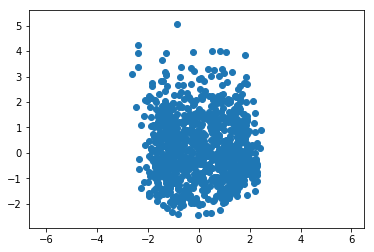

[26] loss: 0.050465 minimaxLoss: 1.527075 advLoss: 0.918127 time: 0.15
[27] loss: 0.048418 minimaxLoss: 0.633628 advLoss: 1.797523 time: 0.24


In [ ]:
import DataProvider as DP
import SimpleLogger as SimpleLogger

import importlib
import numpy as np
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable


import matplotlib.pyplot as plt
from IPython import display
import time

import models.aaegan as aaegan



gpu_id = 0
myseed = 0

DP = importlib.reload(DP)

np.random.seed(myseed)

image_dir = '/root/data/'

opts = {}

opts['verbose'] = True
opts['pattern'] = '*.tif_flat.png'
opts['out_size'] = [64, 64]

data_path = './data_' + str(opts['out_size'][0]) + 'x' + str(opts['out_size'][1]) + '.pyt'

if os.path.exists(data_path):
    dp = torch.load(data_path)
else:
    dp = DP.DataProvider(image_dir, opts)
    torch.save(dp, data_path)


%matplotlib inline
def imshow(img):
#     img = img / 2 + 0.5 # unnormalize

    img = img.numpy()
    if img.ndim == 3:
        img = np.expand_dims(img, 0)
    img = np.transpose(img, [0,2,3,1])
    img = np.concatenate(img[:], 1)

    print(img.shape[0]*10)
    print(img.shape[1]*10)    
    fig = plt.figure(figsize = [img.shape[0]/2, img.shape[1]/2])
    

    ax = fig.add_subplot(111)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(img)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)    
    
    
nlatentdim = 2
encoder = aaegan.Enc(nlatentdim)
decoder = aaegan.Dec(nlatentdim)
adversaryZ = aaegan.EncD(nlatentdim)

encoder.apply(weights_init)
decoder.apply(weights_init)
adversaryZ.apply(weights_init)

encoder.cuda(gpu_id)
decoder.cuda(gpu_id)
adversaryZ.cuda(gpu_id)




learningRate = 0.01
    
criterion = nn.BCELoss()

optEnc = optim.RMSprop(encoder.parameters(), lr=learningRate)
optDec = optim.RMSprop(decoder.parameters(), lr=learningRate)
optZ = optim.RMSprop(adversaryZ.parameters(), lr=learningRate)

batchsize = 64
nepochs = 250

ndat = dp.get_n_train()
ndat = 1000

logger = SimpleLogger.SimpleLogger(('epoch', 'reconLoss', 'minimaxLoss', 'advLoss', 'time'), '[%d] loss: %.6f minimaxLoss: %.6f advLoss: %.6f time: %.2f')

for epoch in range(nepochs): # loop over the dataset multiple times

    rand_inds = np.random.permutation(ndat)
    inds = (rand_inds[i:i+batchsize] for i in range(0, len(rand_inds), batchsize))
    
    zAll = list()
    
    recon_loss = 0.0
    latent_loss = 0.0
    minimax_loss = 0.0
    
    c = 0
    for i in inds:
        start = time.time()
        c += 1
        
        batsize = len(i)
        inputs = Variable(dp.get_images(i, 'train')).cuda(gpu_id)
        
#         #pick a distribution that is obvious when you plot it
        zReal = Variable(torch.Tensor(batsize, nlatentdim).uniform_(-2, 2)).cuda(gpu_id)
        yReal = Variable(torch.ones(batsize)).cuda(gpu_id)
        yFake = Variable(torch.zeros(batsize)).cuda(gpu_id)

        
        # zero the parameter gradients
        optEnc.zero_grad()
        optDec.zero_grad()
        optZ.zero_grad()
        
        #Autoencoder forward
        zFake = encoder(inputs)
        outputs = decoder(zFake)
    
        reconLoss = criterion(outputs, inputs)

        
        ###update the discriminator
        #maximize log(AdvZ(z)) + log(1 - AdvZ(Enc(x)))
        yFakeHat = adversaryZ(zFake.detach())
        errZFake = criterion(yFakeHat, yFake)
        
        yRealHat = adversaryZ(zReal.detach())
        errZReal = criterion(yRealHat, yReal)
        
        latentLoss = errZFake + errZReal
        latentLoss.backward()
        optZ.step()
        
        optZ.zero_grad()
        ###
        
        #advarsary loss
        yFakeHat = adversaryZ(zFake)
        minimaxLoss = criterion(yFakeHat, yReal)
        
        #final autoencoder loss
        loss = reconLoss + minimaxLoss*1E-3
        loss.backward()
        
        optEnc.step()
        optDec.step()
            
        # retain some statistics
        recon_loss += reconLoss.data[0]
        minimax_loss += minimaxLoss.data[0]        
        latent_loss += latentLoss.data[0]

        zAll.append(zFake.data)
        
        stop = time.time()
        deltaT = stop-start
        
        logger.add((epoch+1, reconLoss.data[0], minimaxLoss.data[0] , latentLoss.data[0], deltaT))

    zAll = torch.cat(zAll,0).cpu().numpy()

    plt.gca().cla() 
    plt.scatter(zAll[:,0], zAll[:,1])
    plt.xlim([-4, 4]) 
    plt.ylim([-4, 4])     
    plt.axis('equal')
    display.clear_output(wait=True)
    display.display(plt.gcf()) 
    
    logger.add((epoch+1, recon_loss / c, latent_loss / c, minimax_loss /c, deltaT))
#     print('[%d] loss: %.6f minimaxLoss: %.6f advLoss: %.6f time: %.2f' % )
    
    optEnc.param_groups[0]['lr'] = learningRate*(0.999**epoch)
    optDec.param_groups[0]['lr'] = learningRate*(0.999**epoch)
    optZ.param_groups[0]['lr'] = learningRate*(0.999**epoch)
                  
                  
print('Finished Training')